In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gym
import time
import datetime
import copy
import collections
import cv2
from PIL import Image
import base64
import rpyc # For real robot connection
from importnb import Notebook
with Notebook():
    import config
    import models
    from jetbot_sim_environment import JetbotSimEnv
    # from jetbot_data_collection_client import RemoteJetBot # Import your RemoteJetBot class
    from models import SimpleRewardEstimator
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import display as ipy_display, clear_output
import ipywidgets as widgets

DEBUG:matplotlib.pyplot:Loaded backend inline version unknown.


In [18]:
import logging

# Set the logging level for matplotlib's font manager to WARNING,
# suppressing DEBUG and INFO messages.
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)

# You can also suppress DEBUG messages from matplotlib in general if needed
# logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [12]:
RUN_ON_REAL_ROBOT = False  # Set to True to run on the actual Jetbot, False for simulation

# --- MPC Parameters ---
PREDICTION_HORIZON = 3     # H: How many steps to look ahead (adjust based on performance)
N_SAMPLES = 3            # N: Number of random action sequences to evaluate (adjust)
MAX_EPISODE_STEPS = 5   # Maximum steps to run the episode

# --- Real Robot Parameters (only used if RUN_ON_REAL_ROBOT=True) ---
JETBOT_IP = '192.168.68.60' # <<< !!! UPDATE WITH YOUR JETBOT'S IP !!! [cite: 3]
ACTION_MAP_REAL = {        # Map discrete actions to motor speeds (Left, Right)
    0: (0.0, 0.0),         # Action 0: Stop
    1: (0.12, 0.12)         # Action 1: Move forward slowly (adjust speed as needed)
    # Add more actions if your env.action_space is larger
}
REAL_ROBOT_FRAME_DELAY = 0.1 # Seconds to wait after sending motor command before getting frame

# --- Environment/Model Setup ---
device = config.DEVICE
print(f"Using device: {device}")

# Load the transformation pipeline from config
transform = config.TRANSFORM



Using device: cuda


In [5]:

print("Setting up for SIMULATION execution.")
print("Initializing JetbotSimEnv...")
env = JetbotSimEnv(max_steps=MAX_EPISODE_STEPS)
print("Environment initialized.")
# In simulation mode, the env handles reward estimation internally
reward_estimator = None
robot = None
env_for_planning = env # Use the same env for planning and execution

Setting up for SIMULATION execution.
Initializing JetbotSimEnv...
Loading world model from: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_output\checkpoints\model_best_epoch_70.pth
World model architecture from checkpoint: SimpleUNetV1
World model 'SimpleUNetV1' loaded successfully.
Loading reward estimator from: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_output\reward_estimator\reward_estimator_best.pth
Reward estimator loaded successfully.
Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037
Loaded real dataset with 23037 valid samples for initialization.
Environment initialized.


In [6]:
action_space = env_for_planning.action_space
observation_space = env_for_planning.observation_space # Note: Real robot obs might differ slightly
num_actions = action_space.n
print(f"Action space: {action_space}")
print(f"Observation space: {observation_space}")


Action space: Discrete(2)
Observation space: Box(-1.0, 1.0, (3, 224, 224), float32)


In [7]:
def evaluate_sequence(initial_state_tensors, action_sequence, planning_env):
    """
    Simulates an action sequence from an initial state using the planning_env's models
    without modifying the planning_env's actual state.

    Args:
        initial_state_tensors (tuple): Contains starting state tensors
                                      (current_frame_tensor_batch, prev_frames_tensor_batch).
                                      Shape: (1, C, H, W) and (1, N*C, H, W)
        action_sequence (list): A sequence of discrete actions (e.g., [0, 1, 0]).
        planning_env (JetbotSimEnv): An instance of the env used for its models/logic.

    Returns:
        float: Total predicted reward for the sequence.
    """
    current_frame, prev_frames = initial_state_tensors
    total_reward = 0.0
    local_device = planning_env.device

    # Ensure tensors are on the correct device for simulation
    # Make clones to avoid modifying tensors passed in
    current_frame = current_frame.clone().to(local_device)
    prev_frames = prev_frames.clone().to(local_device)

    # Simulate the sequence step-by-step
    for action in action_sequence:
        action_float = planning_env._action_map[action]
        action_tensor = torch.tensor([[action_float]], dtype=torch.float32, device=local_device)

        with torch.no_grad():
            predicted_next_frame = planning_env._predict_next_frame(
                current_frame, prev_frames, action_tensor
            )
            # Use the *planning env's* reward estimator here
            reward = planning_env._estimate_reward(predicted_next_frame)

        total_reward += reward

        # Update state for the *next* simulation step
        new_prev_frames = torch.cat([prev_frames[:, 3:, :, :], current_frame], dim=1)
        prev_frames = new_prev_frames
        current_frame = predicted_next_frame

    return total_reward

def select_action_mpc(current_frame_tensor_batch, prev_frames_tensor_batch, planning_env):
    """
    Selects the best action using Random Shooting MPC based on current state.

    Args:
        current_frame_tensor_batch (Tensor): Current observation (1, C, H, W).
        prev_frames_tensor_batch (Tensor): History observation (1, N*C, H, W).
        planning_env (JetbotSimEnv): The environment instance used for planning.

    Returns:
        int: The best discrete action to take now.
    """
    best_reward = -float('inf')
    best_action_sequence = None

    initial_state_tensors = (current_frame_tensor_batch, prev_frames_tensor_batch)

    for _ in range(N_SAMPLES):
        action_sequence = np.random.randint(0, planning_env.action_space.n, size=PREDICTION_HORIZON).tolist()
        current_reward = evaluate_sequence(initial_state_tensors, action_sequence, planning_env)
        if current_reward > best_reward:
            best_reward = current_reward
            best_action_sequence = action_sequence

    if best_action_sequence is None:
        print("Warning: No best action sequence found, taking random action.")
        return planning_env.action_space.sample()
    else:
        return best_action_sequence[0]


Starting MPC Control Loop...
Mode: SIMULATION


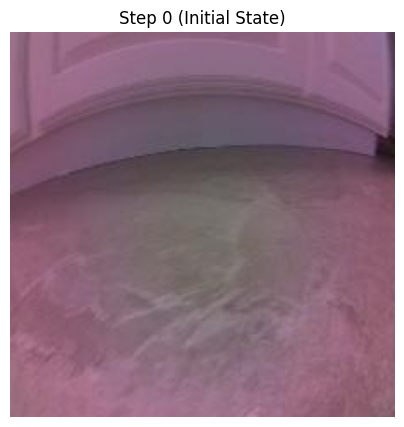

MPC Steps:   0%|          | 0/5 [00:00<?, ?it/s]

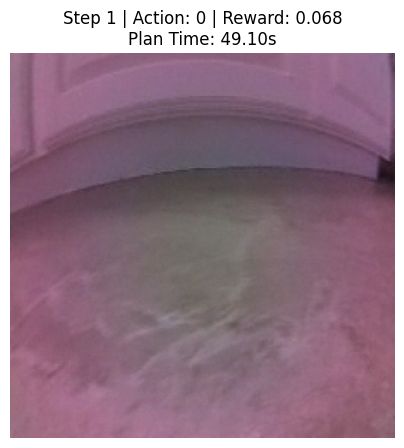

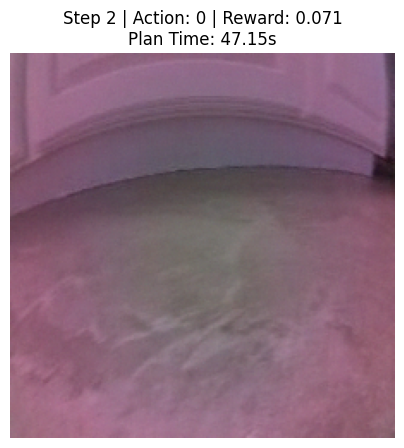

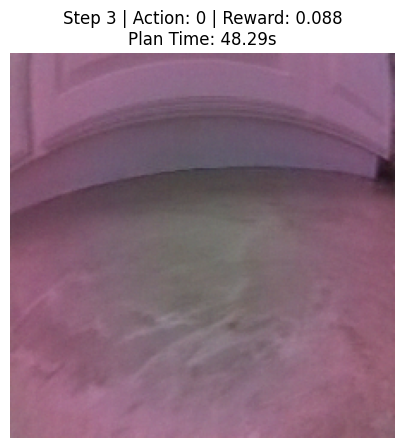

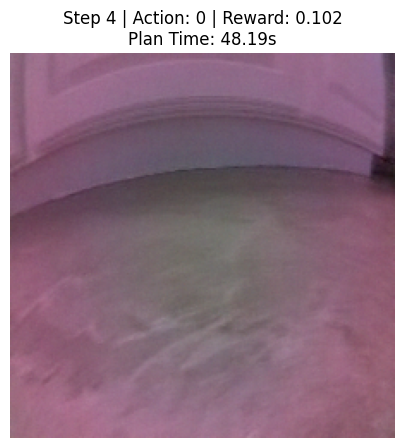

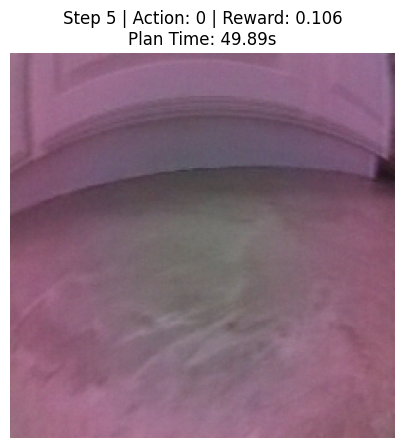


Episode reached max steps (5).
MPC Control Loop finished.
Total Episode Duration: 0:04:30.737631


In [19]:
print("Starting MPC Control Loop...")
print(f"Mode: {'REAL ROBOT' if RUN_ON_REAL_ROBOT else 'SIMULATION'}")

# --- Initialization ---
current_step = 0
done = False
total_actual_reward = 0
episode_actions = []
episode_rewards = []
# Store only the *final* observation tensor for potential later use if needed
final_obs_tensor = None
final_prev_frames_tensor = None

# Timing
loop_start_time = datetime.datetime.now()

# Initial state for Sim
if not RUN_ON_REAL_ROBOT and env:
    sim_obs_np = env.reset()
    current_obs_tensor = env.current_frame_tensor
    prev_frames_tensor = env.prev_frames_tensor
    # Display initial frame
    initial_frame_display = (current_obs_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2
    plt.figure(figsize=(5, 5)) # Adjust size as needed
    plt.imshow(np.clip(initial_frame_display, 0, 1))
    plt.title("Step 0 (Initial State)")
    plt.axis('off')
    plt.show()

# Initial state for Real Robot
elif RUN_ON_REAL_ROBOT and robot:
    print("Initializing real robot state and history buffer...")
    initial_frame_display = None
    for i in range(config.NUM_PREV_FRAMES + 1):
        current_obs_tensor, prev_frames_tensor = get_real_observation_and_update_history(
            robot, transform, frame_history, live_image_widget # Keep live widget update
        )
        if current_obs_tensor is None: done = True; break
        if i == config.NUM_PREV_FRAMES: # Get the last frame for display
             initial_frame_display = (current_obs_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2
        time.sleep(0.1)
    if not done:
        print("Real robot history buffer initialized.")
        # Display initial frame
        plt.figure(figsize=(5, 5)) # Adjust size as needed
        plt.imshow(np.clip(initial_frame_display, 0, 1))
        plt.title("Step 0 (Initial State)")
        plt.axis('off')
        plt.show()

# --- Run Episode ---
try:
    # Use tqdm for progress bar, static plots will appear below
    for step in tqdm(range(MAX_EPISODE_STEPS), desc="MPC Steps", disable=done):
        if done: break

        # 1. Get Current State Tensors
        if RUN_ON_REAL_ROBOT:
             if current_obs_tensor is None or prev_frames_tensor is None: break
        else:
             current_obs_tensor = env.current_frame_tensor
             prev_frames_tensor = env.prev_frames_tensor

        # 2. Select action using MPC
        plan_start_time = time.time()
        action = select_action_mpc(current_obs_tensor, prev_frames_tensor, env_for_planning)
        plan_end_time = time.time()

        # 3. Execute Action
        reward = 0.0
        executed_action = action
        current_frame_display = None

        if RUN_ON_REAL_ROBOT and robot:
            motor_speeds = ACTION_MAP_REAL.get(action, (0.0, 0.0))
            try:
                robot.set_motors(motor_speeds[0], motor_speeds[1])
                time.sleep(REAL_ROBOT_FRAME_DELAY)
                new_obs_tensor, new_prev_frames_tensor = get_real_observation_and_update_history(
                    robot, transform, frame_history, live_image_widget # Keep live widget update
                )
                if new_obs_tensor is None: done = True
                else:
                    reward = estimate_reward_real(new_obs_tensor, reward_estimator)
                    current_obs_tensor = new_obs_tensor # **** Update state for next loop ****
                    prev_frames_tensor = new_prev_frames_tensor # **** Update state for next loop ****
                    current_frame_display = (current_obs_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2
            except Exception as e: done = True; print(f"\nERROR executing action: {e}")

        elif not RUN_ON_REAL_ROBOT and env:
            obs_np, reward, done, info = env.step(action)
            # Need to get the updated tensors from the environment for display
            current_frame_display = (env.current_frame_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) + 1) / 2
            # Update tensors for next loop planning (already done by env.step)
            current_obs_tensor = env.current_frame_tensor
            prev_frames_tensor = env.prev_frames_tensor
        else: break

        # 4. Record results and Display Frame
        if current_frame_display is not None:
             total_actual_reward += reward
             episode_actions.append(executed_action)
             episode_rewards.append(reward)
             final_obs_tensor = current_obs_tensor # Store latest tensors
             final_prev_frames_tensor = prev_frames_tensor

             # Display Current Frame and Action (Statically)
             plt.figure(figsize=(5, 5)) # Create a new figure for each step
             plt.imshow(np.clip(current_frame_display, 0, 1))
             plt.title(f"Step {current_step + 1} | Action: {executed_action} | Reward: {reward:.3f}\nPlan Time: {plan_end_time - plan_start_time:.2f}s")
             plt.axis('off')
             plt.show() # Render the plot for this step

        current_step += 1
        # No sleep needed unless you want to manually slow down the rate plots appear

except KeyboardInterrupt:
    print("\nLoop interrupted by user.")
finally:
    # --- Cleanup ---
    loop_end_time = datetime.datetime.now()
    if RUN_ON_REAL_ROBOT and robot:
        print("Stopping robot motors...")
        try: robot.set_motors(0.0, 0.0); robot.cleanup()
        except Exception as e: print(f"Error during robot cleanup: {e}")
    elif env: env.close()

if not done and current_step >= MAX_EPISODE_STEPS:
    print(f"\nEpisode reached max steps ({MAX_EPISODE_STEPS}).")

# --- Final Timing Info ---
episode_duration = loop_end_time - loop_start_time
print(f"MPC Control Loop finished.")
print(f"Total Episode Duration: {episode_duration}")
